In [91]:
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

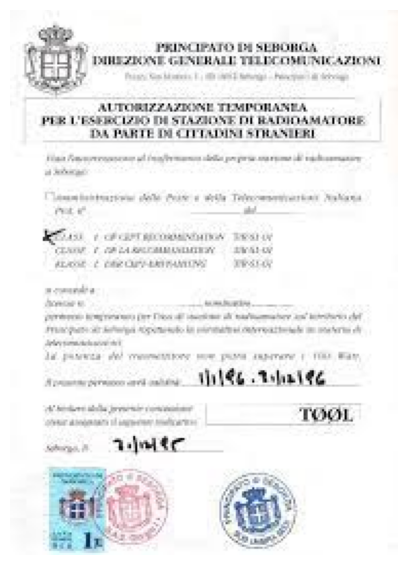

In [110]:
imgFile = "C:\\Users\\HP-Laptop\\Downloads\\stamp_1.jfif"
img = cv2.imread(imgFile)

def imshow(img, showAxis = False, size=(5,10)):
    plt.figure(figsize=size)
    if not showAxis:
        plt.axis('off')
    if len(img.shape) == 3:
        plt.imshow(img[:,:,::-1]) #OpenCV uses BGR instead of RGB hence inverse the color channel
    else:
        plt.imshow(img, cmap='gray')
        
imshow(img)

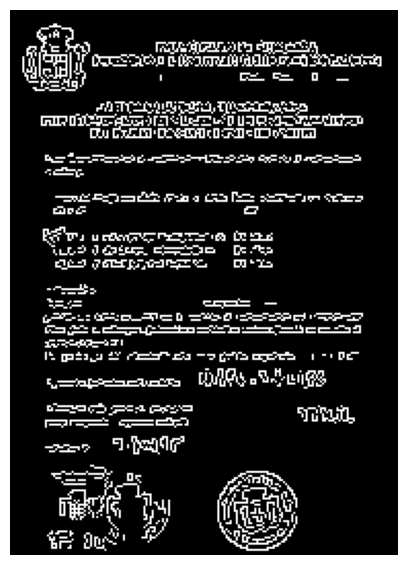

In [111]:
#Convert the image to Grayscale
gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)

#Blur to remove noise (Necessaary for canny detection)
blur = cv2.bilateralFilter(gray.copy(), 15, 15, 15 )

#Find edges using canny edge detector
def auto_canny(grayim, sigma=0.33):
    #compute the median of the single channel pixel intensities
    v = np.median(grayim)
    
    #apply automatic Canny edge detection using the computed median
    #Thresold Calculations
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    
    #Apply the edged detector
    edged = cv2.Canny(grayim, lower, upper)
    # return the edged image
    return edged

#Find the edges and display the image
edged = auto_canny(blur)
imshow(edged)

In [122]:
#Detect the contours
#cv2.RETR_EXTERNAL - detect only the external contours
contours, _ = cv2.findContours(image=edged.copy(), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
print(f'Total nr of contours found: {len(contours)}')

#SortContours by Area and get topN
topN = 3

#cv2.contourArea is the key, reverse = True (descending)
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)                     
sorted_contours = sorted_contours[:topN]

Total nr of contours found: 333


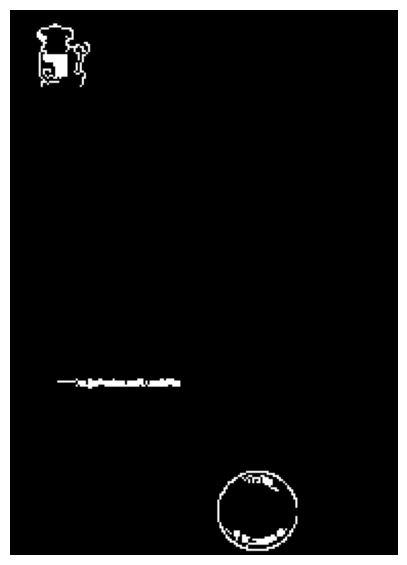

In [123]:
#Create an Empty Binary Image
filteredCircle = np.zeros((img.shape[:2]), dtype =np.uint8)

#Fill the contours
#ContourIDx = -1 , al contours are filled
cv2.drawContours(image=filteredCircle, contours=sorted_contours, contourIdx=-1, color=(255, 255, 255), thickness=cv2.FILLED)
imshow(filteredCircle)

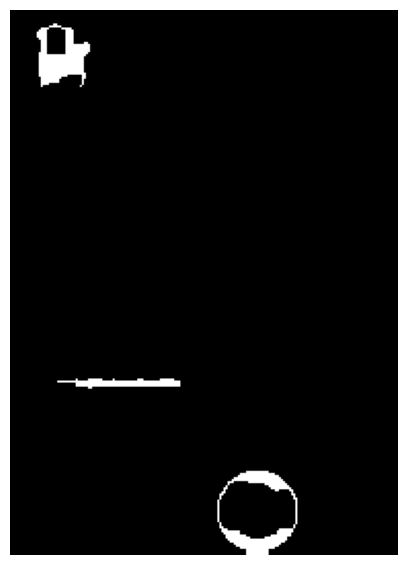

In [127]:
#Create a Kernel
kernel = np.ones((3,3),np.uint8)

#Morphological closing
#cv2.MORPH_CLOSE = The closing operation
#iterations - no of iterations to apply it for
closedCircle = cv2.morphologyEx(filteredCircle, cv2.MORPH_CLOSE, kernel, iterations=2)
imshow(closedCircle)

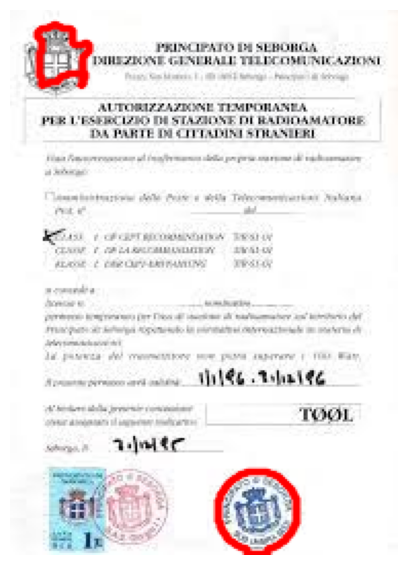

In [128]:
#Find contours from the processed image
filteredContours, _ = cv2.findContours(image=closedCircle.copy(), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)

#Find Contours based on the number of points
circleContours = []
for index, contour in enumerate(filteredContours):
    perimeter = cv2.arcLength(contour,True)
    
    #approximate the contour to reduce the number of points while preserving its shape
    approxPoints = cv2.approxPolyDP(contour, 0.04 * perimeter, True)
    
    #contours with more than 5 points are retained
    if len(approxPoints) > 5: 
        circleContours.append(contour)

# Display the identified stamps
out = img.copy()
cv2.drawContours(image=out, contours=circleContours, contourIdx=-1, color=(0,0,255), thickness=2, lineType=cv2.LINE_AA)
imshow(out)

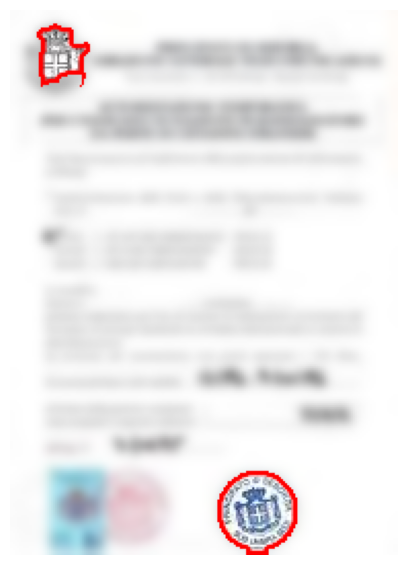

In [129]:
from itertools import product

#Apply Gaussian blur with a kernel size of (15, 15) and standard deviation of 0
highlight_blur = cv2.GaussianBlur(img.copy(), (15,15),0)

#Loop through every point in the image
for y, x in product(range(img.shape[0]), range(img.shape[1])):
    #Loop through all the contours
    for contour in circleContours:
        #Check if the point is on or inside the contour
        if cv2.pointPolygonTest(contour, [x, y], False) >= 0.0:
            #Replace the image with the output image
            highlight_blur[y, x, :] = out[y, x, :]

imshow(highlight_blur)